In [1]:
import os
import yaml
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid, Amazon
from seeds import development_seed, test_seeds
from collections import defaultdict
from scipy import linalg, stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid')

# Backend

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Configuration

In [3]:
with open('config.yaml', 'r') as file:
    CONFIG = yaml.safe_load(file)
    
DATASETS = CONFIG['dataset_names']
DIFFUSION_METHODS = CONFIG['diff_methods']
PAPER_RESULTS = CONFIG['paper_results']

DATA_FOLDER = 'data'

LEARNING_RATE = 0.01
DROPOUT = 0.5

# Data Preprocessing

In [4]:
def get_dataset(dataset_name):
    """
    Return the requested dataset with data containing only the largest connected components
    """
    
    # download/load dataset
    path = os.path.join(DATA_FOLDER, dataset_name)
    if dataset_name in ['Cora', 'Citeseer']:
        dataset = Planetoid(root=path, name=dataset_name)
    elif dataset_name in ['Photo']:
        dataset = Amazon(root=path, name=dataset_name)
    
    #select the largest connected components
    nodes = set(range(dataset.data.x.shape[0]))
    connected_components = []
    while nodes:
        begin = min(nodes)
        conn_comps, queue = set(), set([begin])
        row, col = dataset.data.edge_index.numpy()
        while queue:
            current = queue.pop()
            conn_comps.update([current])
            neighbors = []
            for n in col[np.where(row == current)[0]]:
                if n not in conn_comps and n not in queue:
                    neighbors.append(n)
            queue.update(neighbors)
        connected_components.append(conn_comps)
        nodes = nodes.difference(conn_comps)
    lcc_node_idx = np.argmax(list(map(len, connected_components)))
    lcc_nodes = np.array(list(connected_components[lcc_node_idx]))
    
    lcc_counter = {}
    c = 0
    for n in lcc_nodes:
        lcc_counter[n] = c
        c += 1
    
    # prepare new data to containing the largest connected components
    lcc_x, lcc_y = dataset.data.x[lcc_nodes], dataset.data.y[lcc_nodes]
    row, col = dataset.data.edge_index.numpy()
    edges = [(i,j) for i,j in zip(row,col) if i in lcc_nodes and j in lcc_nodes]
    r, c = zip(*edges)
    edges = [list(map(lambda x: lcc_counter[x], r)), list(map(lambda x: lcc_counter[x], c))]
    lcc_data = Data(x=lcc_x, y=lcc_y, edge_index=torch.LongTensor(edges),
                train_mask=torch.zeros(lcc_y.size()[0], dtype=torch.bool),
                test_mask=torch.zeros(lcc_y.size()[0], dtype=torch.bool),
                val_mask=torch.zeros(lcc_y.size()[0], dtype=torch.bool))
    dataset.data = lcc_data
    
    return dataset

In [5]:
def split_data(data, seed, num_dev_nodes=1500):
    """
    Split the data (nodes) into training, validation and test nodes.
    This is done by modifying the train_, val_ and test_ masks according to the respective indices.
    """
    random = np.random.RandomState(development_seed)
    total_nodes = data.y.shape[0]
    dev_idx = random.choice(total_nodes, num_dev_nodes, replace=False)
    test_idx = [i for i in np.arange(total_nodes) if i not in dev_idx]

    random = np.random.RandomState(seed)
    train_idx = []
    for i in range(data.y.max()+1):
        class_idx = dev_idx[np.where(data.y[dev_idx].cpu() == i)[0]]
        train_idx.extend(random.choice(class_idx, 20, replace=False))

    val_idx = [i for i in dev_idx if i not in train_idx]

    data.train_mask = torch.zeros(total_nodes, dtype=torch.bool)
    data.train_mask[train_idx] = 1
    data.val_mask = torch.zeros(total_nodes, dtype=torch.bool)
    data.val_mask[val_idx] = 1
    data.test_mask = torch.zeros(total_nodes, dtype=torch.bool)
    data.test_mask[test_idx] = 1

    return data

In [6]:
def apply_graph_diffusion(dataset, method, t=5.0, alpha=0.1, k=None, eps=None):
    """
    Apply the graph diffusion algorithm from "Diffusion Improves Graph Learning" <https://arxiv.org/abs/1911.05485> paper.
    """
    total_nodes = dataset.data.x.shape[0]
    
    # compute adjaceny matrix from spare representation of graph data
    adjacency_matrix = torch.zeros((total_nodes, total_nodes))
    for i,j in zip(dataset.data.edge_index[0], dataset.data.edge_index[1]):
        adjacency_matrix[i,j] = 1
    
    # self-loops
    A = adjacency_matrix + torch.eye(total_nodes)
    
    # symmetric transition matrix
    D = torch.diag( 1 / torch.sqrt(A.sum(axis=1)) )
    T_sym = D @ A @ D
    
    # apply graph diffusion
    if method == 'heat':
        diffusion_matrix = torch.matrix_exp( -t * ( torch.eye(total_nodes) - T_sym ))
    elif method == 'ppr':
        diffusion_matrix = alpha * torch.inverse( torch.eye(total_nodes) - (1 - alpha) * T_sym )
    
    # sparsify
    if k:
        rows = np.arange(total_nodes)
        diffusion_matrix[ diffusion_matrix.argsort(axis=0)[:total_nodes-k], rows] = 0
    elif eps:
        diffusion_matrix[diffusion_matrix < eps] = 0
    norm = diffusion_matrix.sum(axis=0)
    norm[norm <= 0] = 1
    diffusion_matrix /= norm
    
    
    # prepare new data for data obtained after applying graph diffusion
    edges_i, edges_j, edge_attr = [], [], []
    for i, row in enumerate(diffusion_matrix):
        for j in np.where(row > 0)[0]:
            edges_i.append(i)
            edges_j.append(j)
            edge_attr.append(diffusion_matrix[i,j])
    edge_index = [edges_i, edges_j]
    data = Data(x=dataset.data.x, y=dataset.data.y,
                edge_index=torch.LongTensor(edge_index),
                edge_attr=torch.FloatTensor(edge_attr),
                train_mask=torch.zeros(dataset.data.train_mask.size()[0], dtype=torch.bool),
                test_mask=torch.zeros(dataset.data.test_mask.size()[0], dtype=torch.bool),
                val_mask=torch.zeros(dataset.data.val_mask.size()[0], dtype=torch.bool))
    dataset.data = data
    
    return dataset

# Model Definitions

In [7]:
MODELS = {}

In [8]:
# Graph Convolutional Network

class GCN(nn.Module):
    
    def __init__(self, dataset, depth, hid_dim=64):
        super(GCN, self).__init__()
        num_features = [dataset.data.x.shape[1]] + [hid_dim]*depth + [dataset.num_classes]
        self.layers = nn.ModuleList()
        for in_features, out_features in zip(num_features[:-1], num_features[1:]):
            self.layers.append( GCNConv(in_features, out_features) )
        
        self.reg_params = list(self.layers[0].parameters())
        self.non_reg_params = list([p for l in self.layers[1:] for p in l.parameters()])
        
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT)
        self.to(device)
        
    def reset_parameters(self):
        for l in self.layers:
            l.reset_parameters()
        
    def forward(self, input_data):
        x, edge_index, edge_attr = input_data.x, input_data.edge_index, input_data.edge_attr
        for layer in self.layers[:-1]:
            x = layer(x, edge_index, edge_weight=edge_attr)
            x = self.activation(x)
            x = self.dropout(x)
        x = self.layers[-1](x, edge_index, edge_weight=edge_attr)
        x = nn.LogSoftmax(dim=1)(x)
        return x
    
MODELS['GCN'] = GCN

In [22]:
# Graph Attention Network

class GAT(nn.Module):
    
    def __init__(self, dataset, depth, hid_dim=64):
        super(GAT, self).__init__()
        num_features = [hid_dim]*depth
        h = 1
        self.layers = nn.ModuleList()
        self.layers.append( GATConv(dataset.data.x.shape[1], hid_dim, heads=h) )
        for _ in range(depth-1):
            self.layers.append( GATConv(hid_dim*h, hid_dim, heads=h) )
        self.layers.append( GATConv(hid_dim*h, dataset.num_classes, concat=False) )
        
        self.reg_params = list(self.layers[0].parameters())
        self.non_reg_params = list([p for l in self.layers[1:] for p in l.parameters()])
        
        self.activation = nn.ELU()
        self.dropout = nn.Dropout(p=DROPOUT)
        self.to(device)
        
    def reset_parameters(self):
        for l in self.layers:
            l.reset_parameters()
        
    def forward(self, input_data):
        x, edge_index, edge_attr = input_data.x, input_data.edge_index, input_data.edge_attr
        for layer in self.layers[:-1]:
            x = layer(x, edge_index, edge_attr=edge_attr)
            x = self.activation(x)
            x = self.dropout(x)
        x = self.layers[-1](x, edge_index, edge_attr=edge_attr)
        x = nn.LogSoftmax(dim=1)(x)
        return x
    
MODELS['GAT'] = GAT

In [10]:
# Jumping Knowledge Network

class JK(nn.Module):
    
    def __init__(self, dataset, depth):
        super(JK, self).__init__()
        num_features = [dataset.data.x.shape[1]] + [64]*depth
        self.layers = nn.ModuleList()
        for in_features, out_features in zip(num_features[:-1], num_features[1:]):
            self.layers.append( GCNConv(in_features, out_features) )
        self.layers.append( nn.Linear(64*depth, dataset.num_classes) )
        
        self.reg_params = list(self.layers[0].parameters())
        self.non_reg_params = list([p for l in self.layers[1:] for p in l.parameters()])
        
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT)
        self.to(device)
        
    def reset_parameters(self):
        for l in self.layers:
            l.reset_parameters()
        
    def forward(self, input_data):
        layer_outputs = []
        x, edge_index, edge_attr = input_data.x, input_data.edge_index, input_data.edge_attr
        for layer in self.layers[:-1]:
            x = layer(x, edge_index, edge_weight=edge_attr)
            x = self.activation(x)
            x = self.dropout(x)
            layer_outputs.append(x)
        x = torch.cat(layer_outputs, dim=-1)
        x = self.layers[-1](x)
        x = nn.LogSoftmax(dim=1)(x)
        return x
    
MODELS['JK'] = JK

# Training & Evaluation

In [11]:
def train_model(model, optimizer, data):
    """
    Train model with backpropagation.
    """
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = nn.NLLLoss()(output[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [12]:
def evaluate_model(model, data):
    """
    Evaluate model on the validation and test data.
    """
    model.eval()
    with torch.no_grad():
        output = model(data)
    evaluation = {}
    keys = ['val', 'test']
    for k in keys:
        mask = data[f'{k}_mask']
        pred = output[mask].max(1)[1]
        accuracy = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        evaluation[k] = accuracy
    return evaluation

In [13]:
def run(dataset, model, seeds, diff_method, params):
    """
    Train and evalaute a model for a given dataset and diffusion method using the given params.
    """
    
    best_history = defaultdict(list)
    
    for seed in seeds:
        dataset.data = split_data(dataset.data, seed).to(device)
        model.reset_parameters()
        optimizer = optim.Adam(
            [
                {'params': model.non_reg_params, 'weight_decay': 0},
                {'params': model.reg_params, 'weight_decay': params['weight_decay']}
            ],
            lr = LEARNING_RATE
        )
        
        patience_ctr = 0
        temp = {'val': 0}
        
        for _ in range(10000):
            train_model(model, optimizer, dataset.data)
            evaluation = evaluate_model(model, dataset.data)
            
            if evaluation['val'] >= temp['val']:
                patience_ctr = 0
                temp['val'] = evaluation['val']
                temp['test'] = evaluation['test']
            else:
                patience_ctr += 1

            if patience_ctr == 100:
                break
                
        for k,v in temp.items():
            best_history[k].append(v)
        
    return dict(best_history)

In [23]:
def run_for_model(mname):
    """
    Run the algorithm for all dataset-diffusion combination for a given model.
    """
    
    with open('results.yaml', 'r') as file:
        saved_results = yaml.safe_load(file)
    
    for dname in DATASETS:
        print(f"\n{dname}")
        print(f"    {mname}")
        for diff in DIFFUSION_METHODS:
            params = CONFIG[mname][diff][dname]
            dataset = get_dataset(dname)
            if diff == 'heat':
                dataset = apply_graph_diffusion(dataset, 'heat', t=params['t'], k=params['k'], eps=params['eps'])
            elif diff == 'ppr':
                dataset = apply_graph_diffusion(dataset, 'ppr', alpha=params['alpha'], k=params['k'], eps=params['eps'])
            model = MODELS[mname](dataset, params['depth'])
            results[f"{dname}-{mname}-{diff}"] = run(dataset, model, test_seeds, diff, params)
            saved_results[dname][mname][diff] = float(np.round( 100*np.mean(results[f'{dname}-{mname}-{diff}']['test']), decimals=2 ))
            print(f"\t{diff}: {saved_results[dname][mname][diff]:.2f}")

    with open('results.yaml', 'w') as file:
        yaml.safe_dump(saved_results, file)

In [15]:
results = {}

In [16]:
run_for_model('GCN')


Cora
    GCN
	none: 81.69
	heat: 83.20
	ppr: 83.32

Citeseer
    GCN
	none: 71.99
	heat: 72.53
	ppr: 72.39

Photo
    GCN
	none: 92.04
	heat: 89.24
	ppr: 92.67


In [24]:
run_for_model('GAT')


Cora
    GAT
	none: 80.17
	heat: 79.43
	ppr: 80.10

Citeseer
    GAT
	none: 70.43
	heat: 69.93
	ppr: 68.10

Photo
    GAT
	none: 91.16
	heat: 89.64
	ppr: 88.85


In [25]:
run_for_model('JK')


Cora
    JK
	none: 81.28
	heat: 82.97
	ppr: 83.13

Citeseer
    JK
	none: 69.28
	heat: 71.00
	ppr: 71.80

Photo
    JK
	none: 91.52
	heat: 91.67
	ppr: 92.47


# Results

In [26]:
for _,best in results.items():
    boots = stats.bootstrap((best['val'],), np.mean, n_resamples=1000, method='percentile')
    best['val_ci'] = 100*np.max(np.abs(boots.confidence_interval - np.mean(best['val'])))
    best['val'] = 100*np.mean(best['val'])
    boots = stats.bootstrap((best['test'],), np.mean, n_resamples=1000, method='percentile')
    best['test_ci'] = 100*np.max(np.abs(boots.confidence_interval - np.mean(best['test'])))
    best['test'] = 100*np.mean(best['test'])

In [27]:
for d, r in results.items():
    print(f"{d}: {r['test']:.2f} +- {r['test_ci']:.2f}%")

Cora-GCN-none: 81.69 +- 0.25%
Cora-GCN-heat: 83.20 +- 0.22%
Cora-GCN-ppr: 83.32 +- 0.20%
Citeseer-GCN-none: 71.99 +- 0.31%
Citeseer-GCN-heat: 72.53 +- 0.30%
Citeseer-GCN-ppr: 72.39 +- 0.25%
Photo-GCN-none: 92.04 +- 0.21%
Photo-GCN-heat: 89.24 +- 0.26%
Photo-GCN-ppr: 92.67 +- 0.21%
Cora-GAT-none: 80.17 +- 0.28%
Cora-GAT-heat: 79.43 +- 0.26%
Cora-GAT-ppr: 80.10 +- 0.28%
Citeseer-GAT-none: 70.43 +- 0.32%
Citeseer-GAT-heat: 69.93 +- 0.29%
Citeseer-GAT-ppr: 68.10 +- 0.23%
Photo-GAT-none: 91.16 +- 0.28%
Photo-GAT-heat: 89.64 +- 0.29%
Photo-GAT-ppr: 88.85 +- 0.25%
Cora-JK-none: 81.28 +- 0.28%
Cora-JK-heat: 82.97 +- 0.22%
Cora-JK-ppr: 83.13 +- 0.22%
Citeseer-JK-none: 69.28 +- 0.35%
Citeseer-JK-heat: 71.00 +- 0.33%
Citeseer-JK-ppr: 71.80 +- 0.33%
Photo-JK-none: 91.52 +- 0.26%
Photo-JK-heat: 91.67 +- 0.21%
Photo-JK-ppr: 92.47 +- 0.22%


# Visualize Results

In [28]:
with open('results.yaml', 'r') as file:
    saved_results = yaml.safe_load(file)
saved_results

{'Citeseer': {'GAT': {'heat': 69.93, 'none': 70.43, 'ppr': 68.1},
  'GCN': {'heat': 72.53, 'none': 71.99, 'ppr': 72.39},
  'JK': {'heat': 71.0, 'none': 69.28, 'ppr': 71.8}},
 'Cora': {'GAT': {'heat': 79.43, 'none': 80.17, 'ppr': 80.1},
  'GCN': {'heat': 83.2, 'none': 81.69, 'ppr': 83.32},
  'JK': {'heat': 82.97, 'none': 81.28, 'ppr': 83.13}},
 'Photo': {'GAT': {'heat': 89.64, 'none': 91.16, 'ppr': 88.85},
  'GCN': {'heat': 89.24, 'none': 92.04, 'ppr': 92.67},
  'JK': {'heat': 91.67, 'none': 91.52, 'ppr': 92.47}}}

In [29]:
def compare_data_results(dataset, width=0.25):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(16,8))
    x_labels = list(MODELS.keys())
    x_axis = np.arange(len(x_labels))

    for i,res in enumerate([PAPER_RESULTS, saved_results]):
        plot_data = res[dataset]
        subplot = ax[i]
        for j,diff in enumerate(DIFFUSION_METHODS):
            y_values = [plot_data[model][diff] for model in MODELS]
            subplot.bar(
                x = x_axis + width*(j-1),
                height = y_values,
                width = width,
                label = diff,
                tick_label = x_labels if j==1 else None
            )
        subplot.set_ylim(50,100)
        subplot.set_xlabel('Model', fontsize=15)
        subplot.set_ylabel('Accuracy %', fontsize=15)
        subplot.set_title('Project Results' if i else 'Paper Results', fontsize=20)
        subplot.legend(fontsize=12)

    fig.suptitle(dataset.upper(), fontsize=30, fontweight='bold')
    plt.savefig(f"plots/{dataset}-compare.png")
    plt.show()

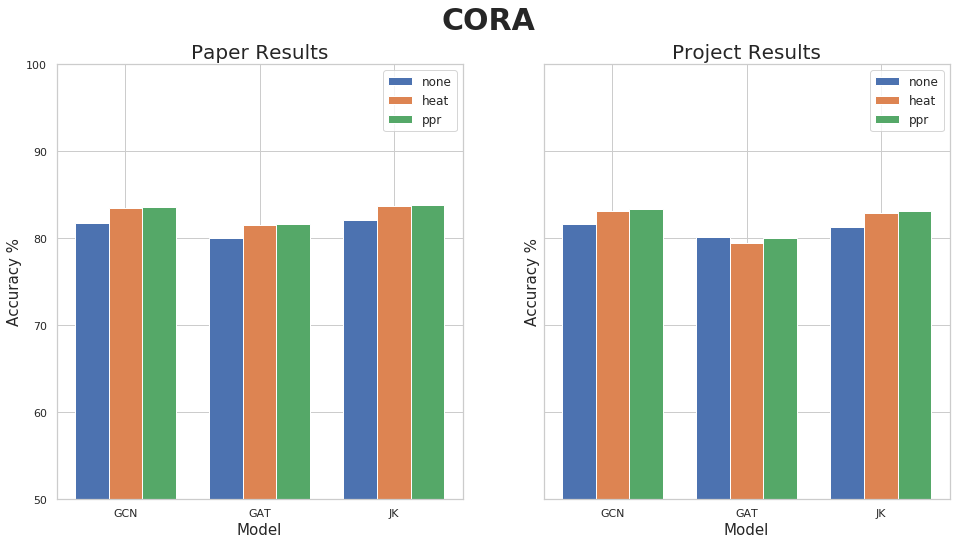

In [30]:
compare_data_results('Cora')

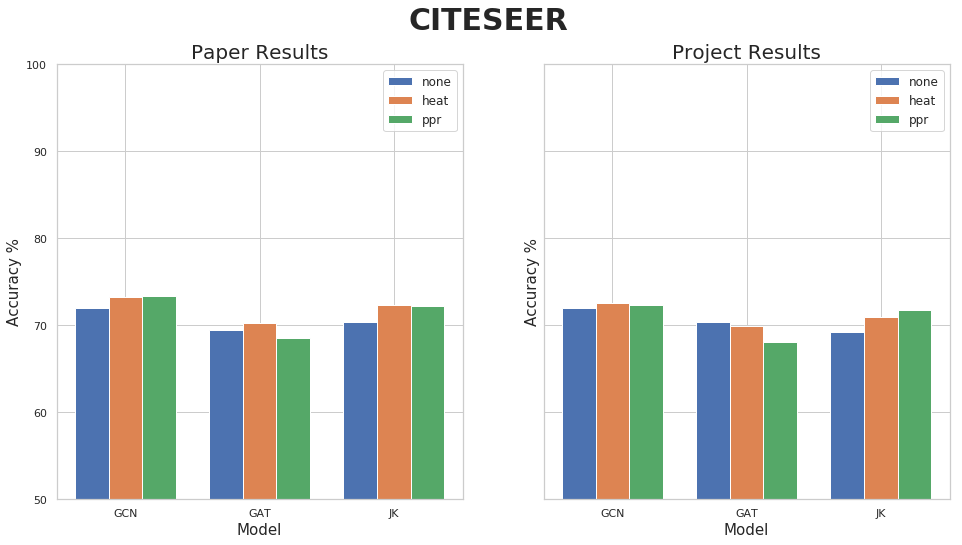

In [31]:
compare_data_results('Citeseer')

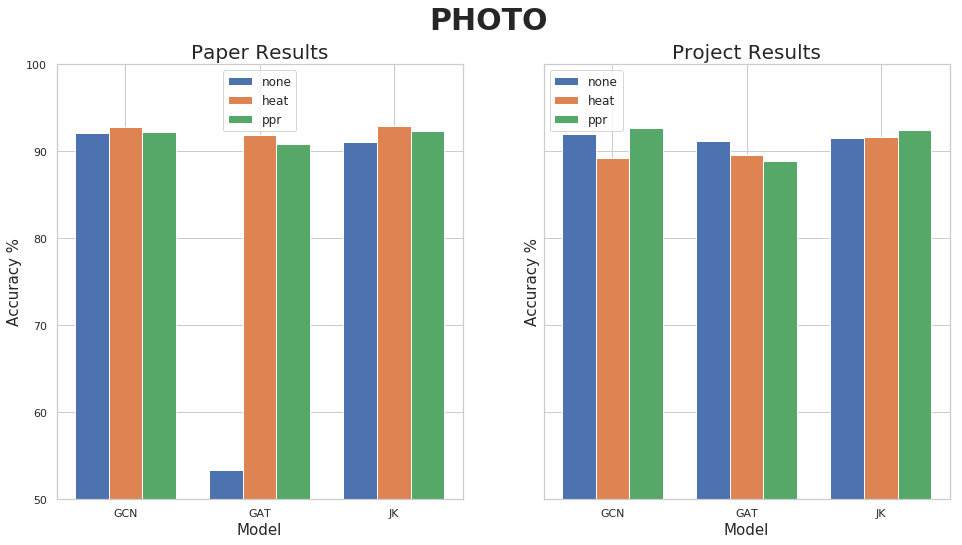

In [32]:
compare_data_results('Photo')

In [33]:
def compare_diff_results(width=0.25):
    fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(16,20))
    x_labels = DIFFUSION_METHODS
    x_axis = np.arange(len(x_labels))
    
    for i, dataset in enumerate(DATASETS):
        for j, model in enumerate(MODELS):
            subplot = ax[i][j]
            for k, res in enumerate([PAPER_RESULTS, saved_results]):
                y_values = [res[dataset][model][diff] for diff in DIFFUSION_METHODS]
                subplot.bar(
                    x = x_axis + width*(k-1),
                    height = y_values,
                    width = width,
                    label = "Project" if k else "Paper",
                    tick_label = x_labels
                )
        
                subplot.set_ylim(50,100)
                subplot.set_xlabel('Diffusion', fontsize=15)
                subplot.set_ylabel('Accuracy %', fontsize=15)
                subplot.set_title(f"{dataset} - {model}", fontsize=20)
                subplot.legend(fontsize=12)

    fig.suptitle("Direct Comparison of Evaluation Results".upper(), fontsize=30, fontweight='bold')
    plt.savefig(f"plots/diff-method-compare.png")
    plt.show()

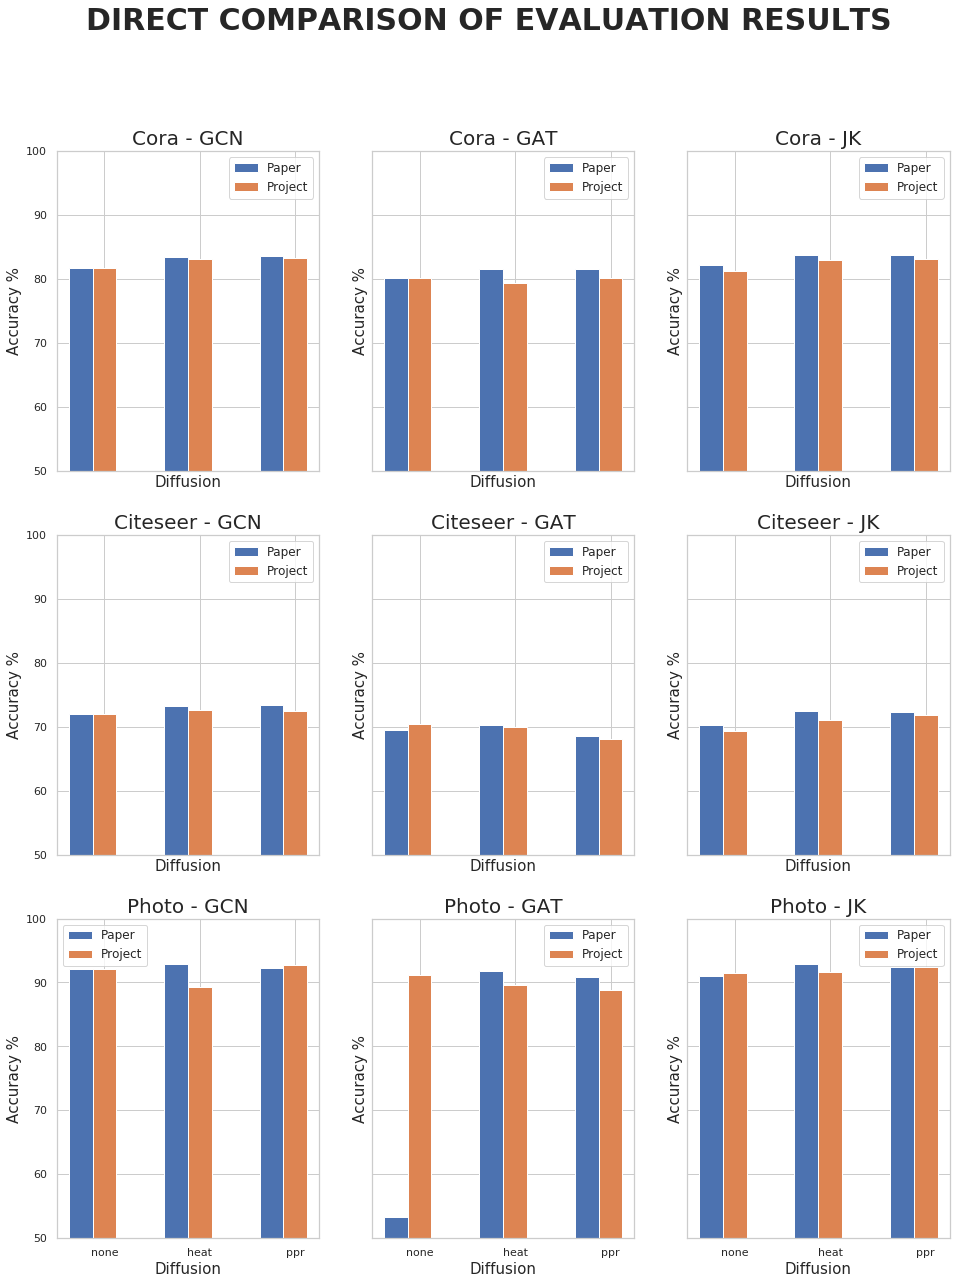

In [34]:
compare_diff_results()

In [35]:
def summarize_dataset_results(width=0.25):
    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10,18))
    x_labels = list(MODELS.keys())
    x_axis = np.arange(len(x_labels))
    
    for i, dataset in enumerate(DATASETS):
        subplot = ax[i]
        for j, diff in enumerate(DIFFUSION_METHODS):
            y_values = [saved_results[dataset][model][diff] for model in MODELS]
            subplot.bar(
                x = x_axis + width*(j-1),
                height = y_values,
                width = width,
                label = diff,
                tick_label = x_labels if j==1 else None
            )
        
            subplot.set_ylim(50,100)
            subplot.set_xlabel('Model', fontsize=15)
            subplot.set_ylabel('Accuracy %', fontsize=15)
            subplot.set_title(f"{dataset}", fontsize=20)
            subplot.legend(fontsize=12)

    fig.suptitle("Summary of Project Results obtained".upper(), fontsize=30, fontweight='bold')
    plt.savefig(f"plots/data-res-summary.png")
    plt.show()

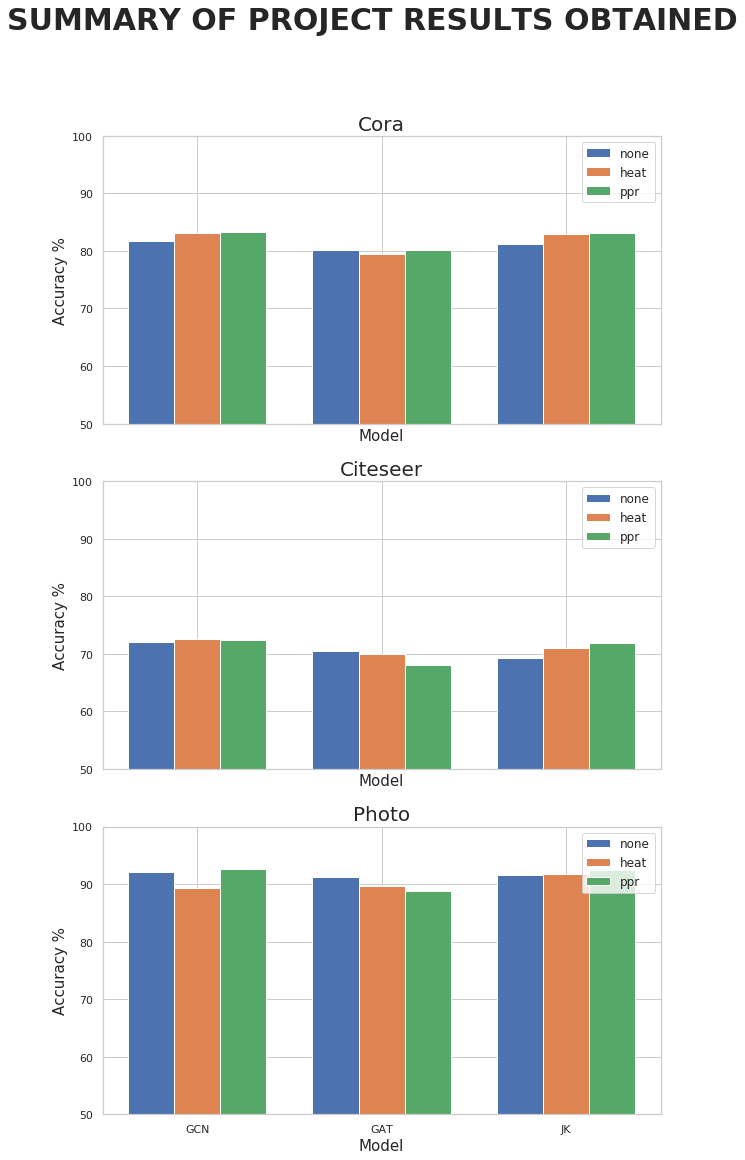

In [36]:
summarize_dataset_results()

In [37]:
def summarize_paper_results(width=0.25):
    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10,18))
    x_labels = list(MODELS.keys())
    x_axis = np.arange(len(x_labels))
    
    for i, dataset in enumerate(DATASETS):
        subplot = ax[i]
        for j, diff in enumerate(DIFFUSION_METHODS):
            y_values = [PAPER_RESULTS[dataset][model][diff] for model in MODELS]
            subplot.bar(
                x = x_axis + width*(j-1),
                height = y_values,
                width = width,
                label = diff,
                tick_label = x_labels if j==1 else None
            )
        
            subplot.set_ylim(50,100)
            subplot.set_xlabel('Model', fontsize=15)
            subplot.set_ylabel('Accuracy %', fontsize=15)
            subplot.set_title(f"{dataset}", fontsize=20)
            subplot.legend(fontsize=12)

    fig.suptitle("Summary of Results from paper".upper(), fontsize=30, fontweight='bold')
    plt.savefig(f"plots/paper-res-summary.png")
    plt.show()

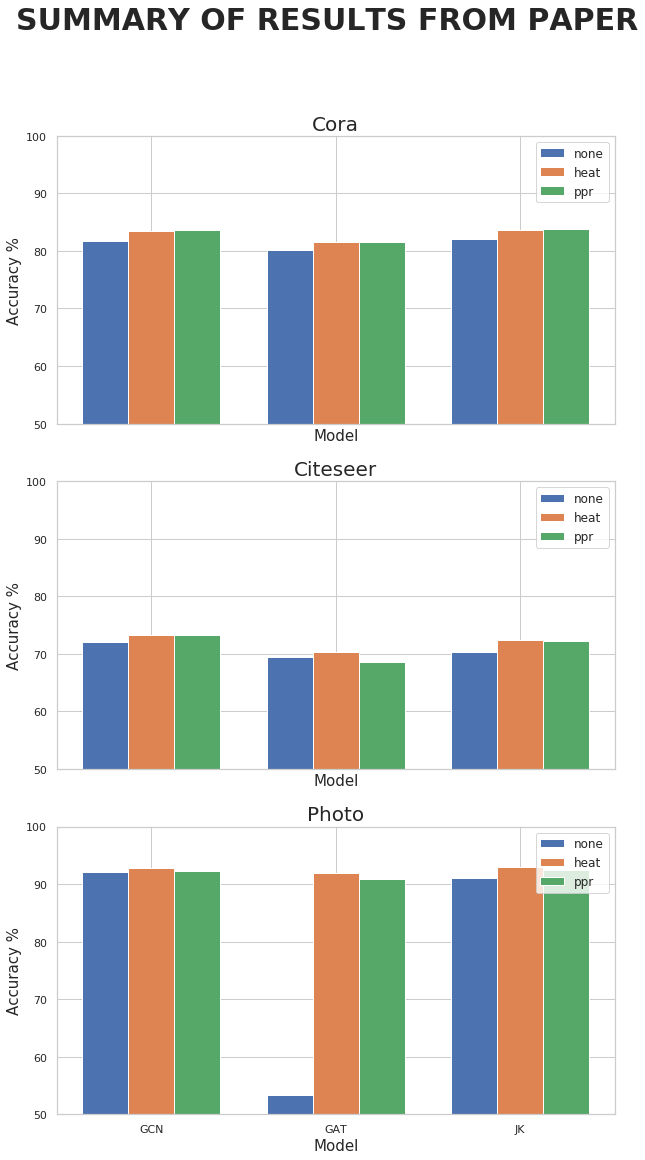

In [38]:
summarize_paper_results()

In [39]:
def best_accuracy(width=0.25):
    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(8,12))
    x_labels = DATASETS
    x_axis = np.arange(len(x_labels))
    
    for i, diff in enumerate(DIFFUSION_METHODS):
        subplot = ax[i]
        for j, res in enumerate([PAPER_RESULTS, saved_results]):
            y_values = [max([res[dataset][model][diff] for model in MODELS]) for dataset in DATASETS]
            subplot.bar(
                x = x_axis + width*(j-1),
                height = y_values,
                width = width,
                label = "Project" if j else "Paper",
                tick_label = x_labels if j==0 else None
            )
        
            subplot.set_ylim(70,95)
            subplot.set_xlabel('Dataset', fontsize=15)
            subplot.set_ylabel('Accuracy %', fontsize=15)
            subplot.set_title(f"{diff}", fontsize=20)
            subplot.legend(fontsize=12)

    fig.suptitle("best accuracies".upper(), fontsize=30, fontweight='bold')
    plt.savefig(f"plots/best-accuracy.png")
    plt.show()

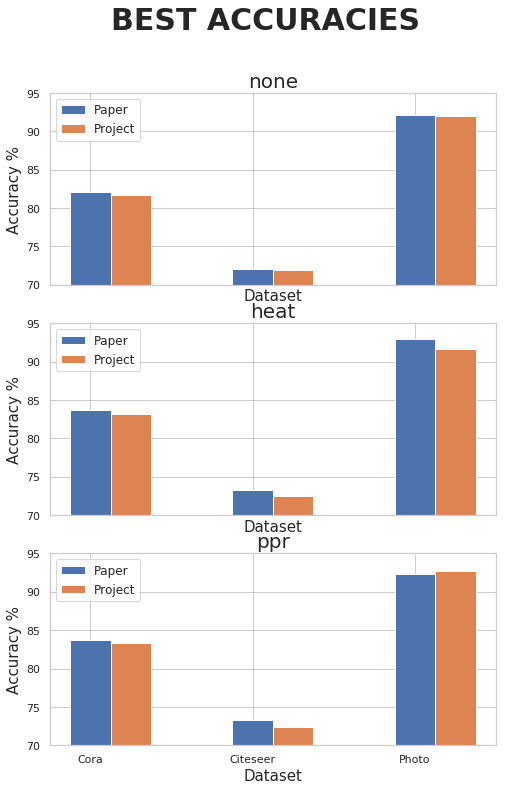

In [40]:
best_accuracy()

## References:
* Paper: [Diffusion Improves Graph Learning](https://arxiv.org/abs/1911.05485)
* Official Code: https://github.com/gasteigerjo/gdc
* GCN: [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907)
* GAT: [Graph Attention Networks](https://arxiv.org/abs/1710.10903)
* JK: [Representation Learning on Graphs with Jumping Knowledge Networks](https://arxiv.org/abs/1806.03536)